In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as st
import theano.tensor as tt

In /home/osvaldo/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/osvaldo/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/osvaldo/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/osvaldo/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/osvaldo/anaconda3/lib/python3.7/site-packages/m

In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams['figure.dpi'] = 300
np.random.seed(7126)

# Survival of seeds


This example is based on the [golf putting](https://mc-stan.org/users/documentation/case-studies/golf.html) case study from Stan documentation and its [adaptation](https://docs.pymc.io/notebooks/putting_workflow.html) to PyMC3.

In [3]:
survival_data = pd.read_csv("survival_data.csv", sep=" ")
distance, tries, successes = survival_data.values.T

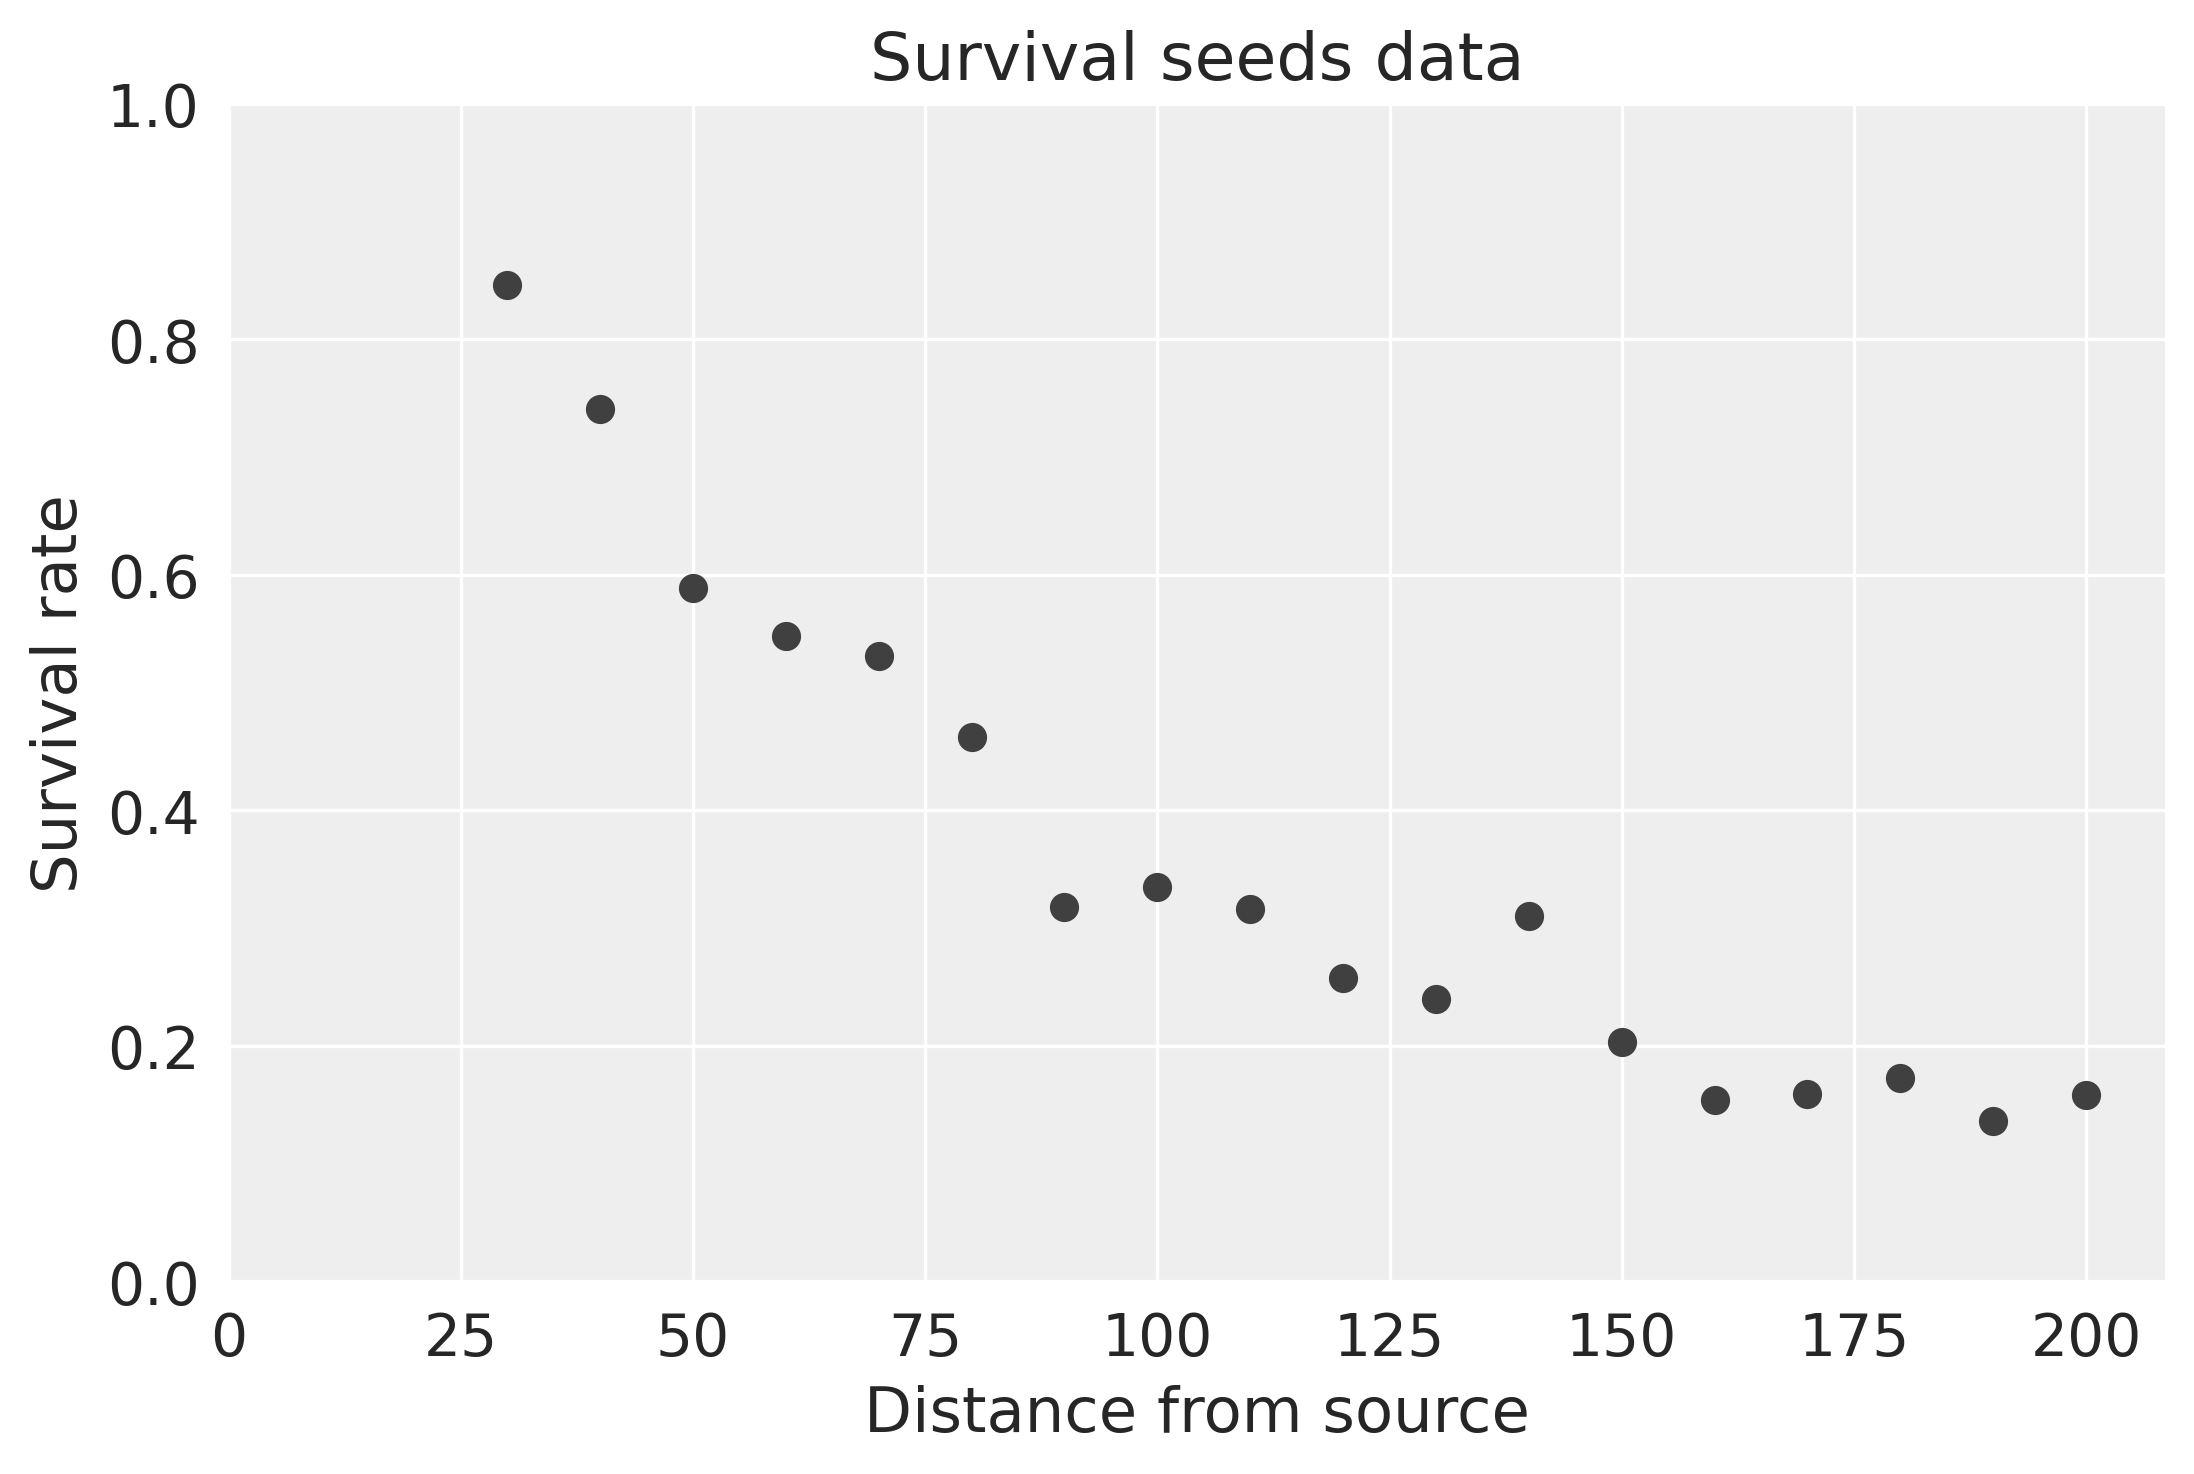

In [4]:
def plot_survival_data(data):
    """Utility function for plotting of the seeds data."""
    _, ax = plt.subplots()

    ax.plot(data.distance,
            data.successes / data.tries,
            "o",
            color="0.25")

    ax.set_xlabel("Distance from source")
    ax.set_ylabel("Survival rate")
    ax.tick_params(axis='x', pad=7)
    ax.tick_params(axis='y', pad=7)
    ax.set_ylim(0, 1)
    ax.set_xlim(0)
    return ax


ax = plot_survival_data(survival_data)
ax.set_title("Survival seeds data")
plt.savefig("survival_seeds_data.png")

After plotting, we see that the chance of survival decreased as the distance to suitable soil increase. Note that this data has been pre-aggregated, in general it is preferred to work with the most granular data available, because we loose information in aggregation 

## Logistic regression model

As we want to model the rate of survival (i.e. the probability of success) of seeds as function of distance to suitable soil. An standard solution would be to perform a logistic regression:

\begin{align}
\alpha \sim &\, \mathcal{N}(\mu_a, sd_a) \\
\beta \sim &\, \mathcal{N}(\mu_b, sd_b) \\
\theta =&\, \operatorname{logistic}(\alpha + \beta \, \text{distance}) \\ 
Y \sim&\, \operatorname{Binomial}(\text{tries}, \theta)
\end{align}

EXPAND THIS explanation We have some intuition that $\beta$ should be negative, and also that $\alpha$ should be positive, since when $\text{distance} = 0$, we expect nearly XX% (NO IDEA what is considered as a high germination rate, but I guess is not 100, maybe 80-90?) of seeds to germinate. Nevertheless we can start with a baseline model that do not include that information and wait and see if we need to add stronger priors. A rather vague priors fro this problem could then be:

$$
\alpha \sim \mathcal{N}(0, 1) \\
\beta \sim \mathcal{N}(0, 1) \\
$$

Using PyMC3 we can write this model in the following way:

In [5]:
with pm.Model() as logistic_model:
    # Priors
    α = pm.Normal("α", 0, 1)
    β = pm.Normal("β", 0, 1)
    # linear model with logistic transformation
    θ = pm.math.invlogit(α + β * distance)
    
    # Likelihood
    Y = pm.Binomial("Y",
                    n=tries,
                    p=θ,
                    observed=successes,
                    )
    # Sampling from the posterior
    idata_logistic = pm.sample(1000, tune=2000,
                               return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8887348294231564, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8829805062896093, but should be close to 0.8. Try to increase the number of tuning steps.


Now that we have check that the sampling process is at least OK, we can start exploring the posterior 

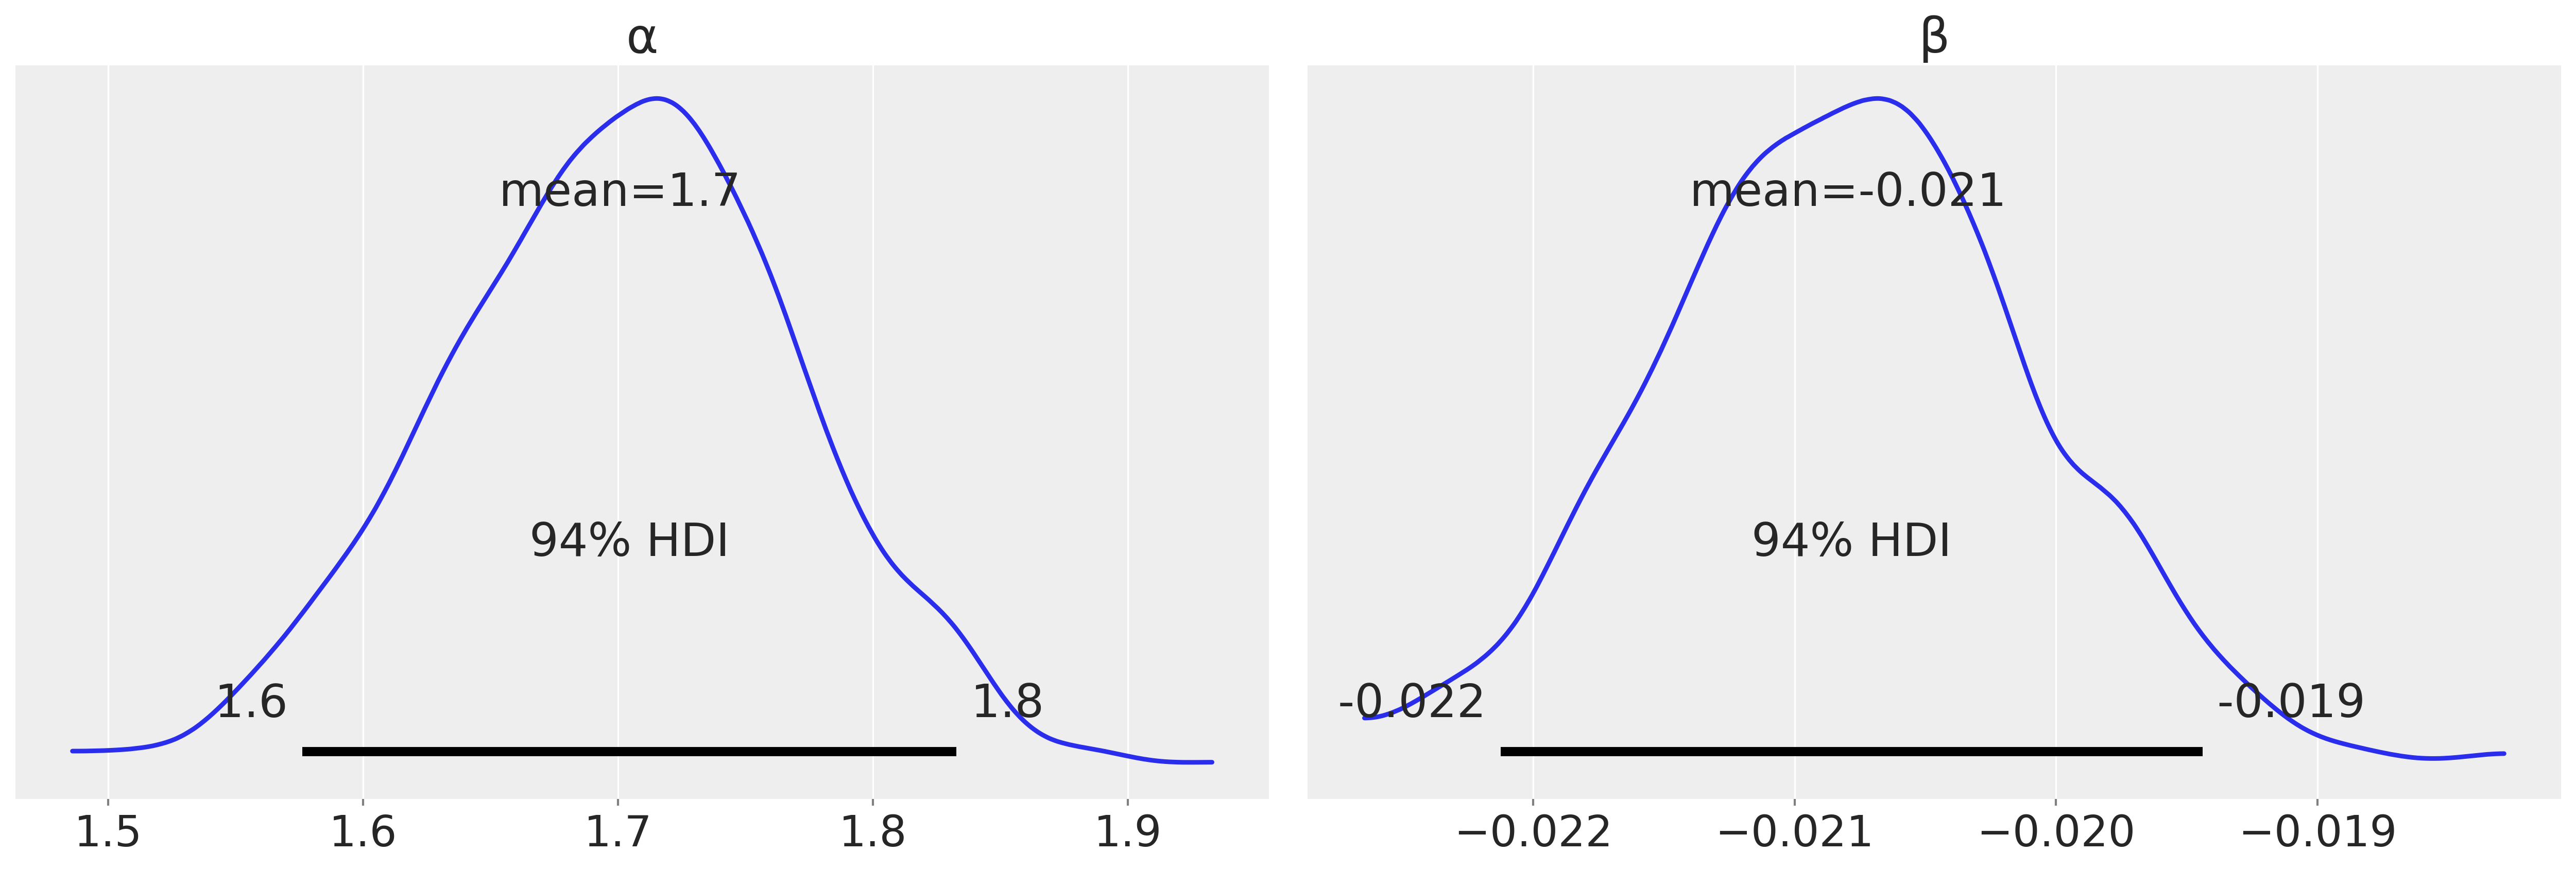

In [6]:
az.plot_posterior(idata_logistic, round_to=2, textsize=20)
plt.savefig("logistic_posterior.png")

In [7]:
az.summary(idata_logistic, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
α,1.70,0.07,1.58,1.83
β,-0.02,0.00,-0.02,-0.02


In [8]:
#print(az.summary(idata_logistic, kind="stats", round_to=2).to_latex())

We see $\alpha$ and $\beta$ have the signs we expected. There were no bad warnings emitted from the sampler. Looking at the summary, the number of effective samples is reasonable, and the rhat is close to 1. This is a small model, so we are not being too careful about inspecting the fit.

We plot 50 posterior draws of $p(\text{success})$ along with the expected value. Also, we draw 500 points from the posterior predictive to plot:

In [9]:
# Draw posterior predictive samples
logistic_ppc = pm.sample_posterior_predictive(idata_logistic, model=logistic_model)

/home/osvaldo/proyectos/00_BM/arviz/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


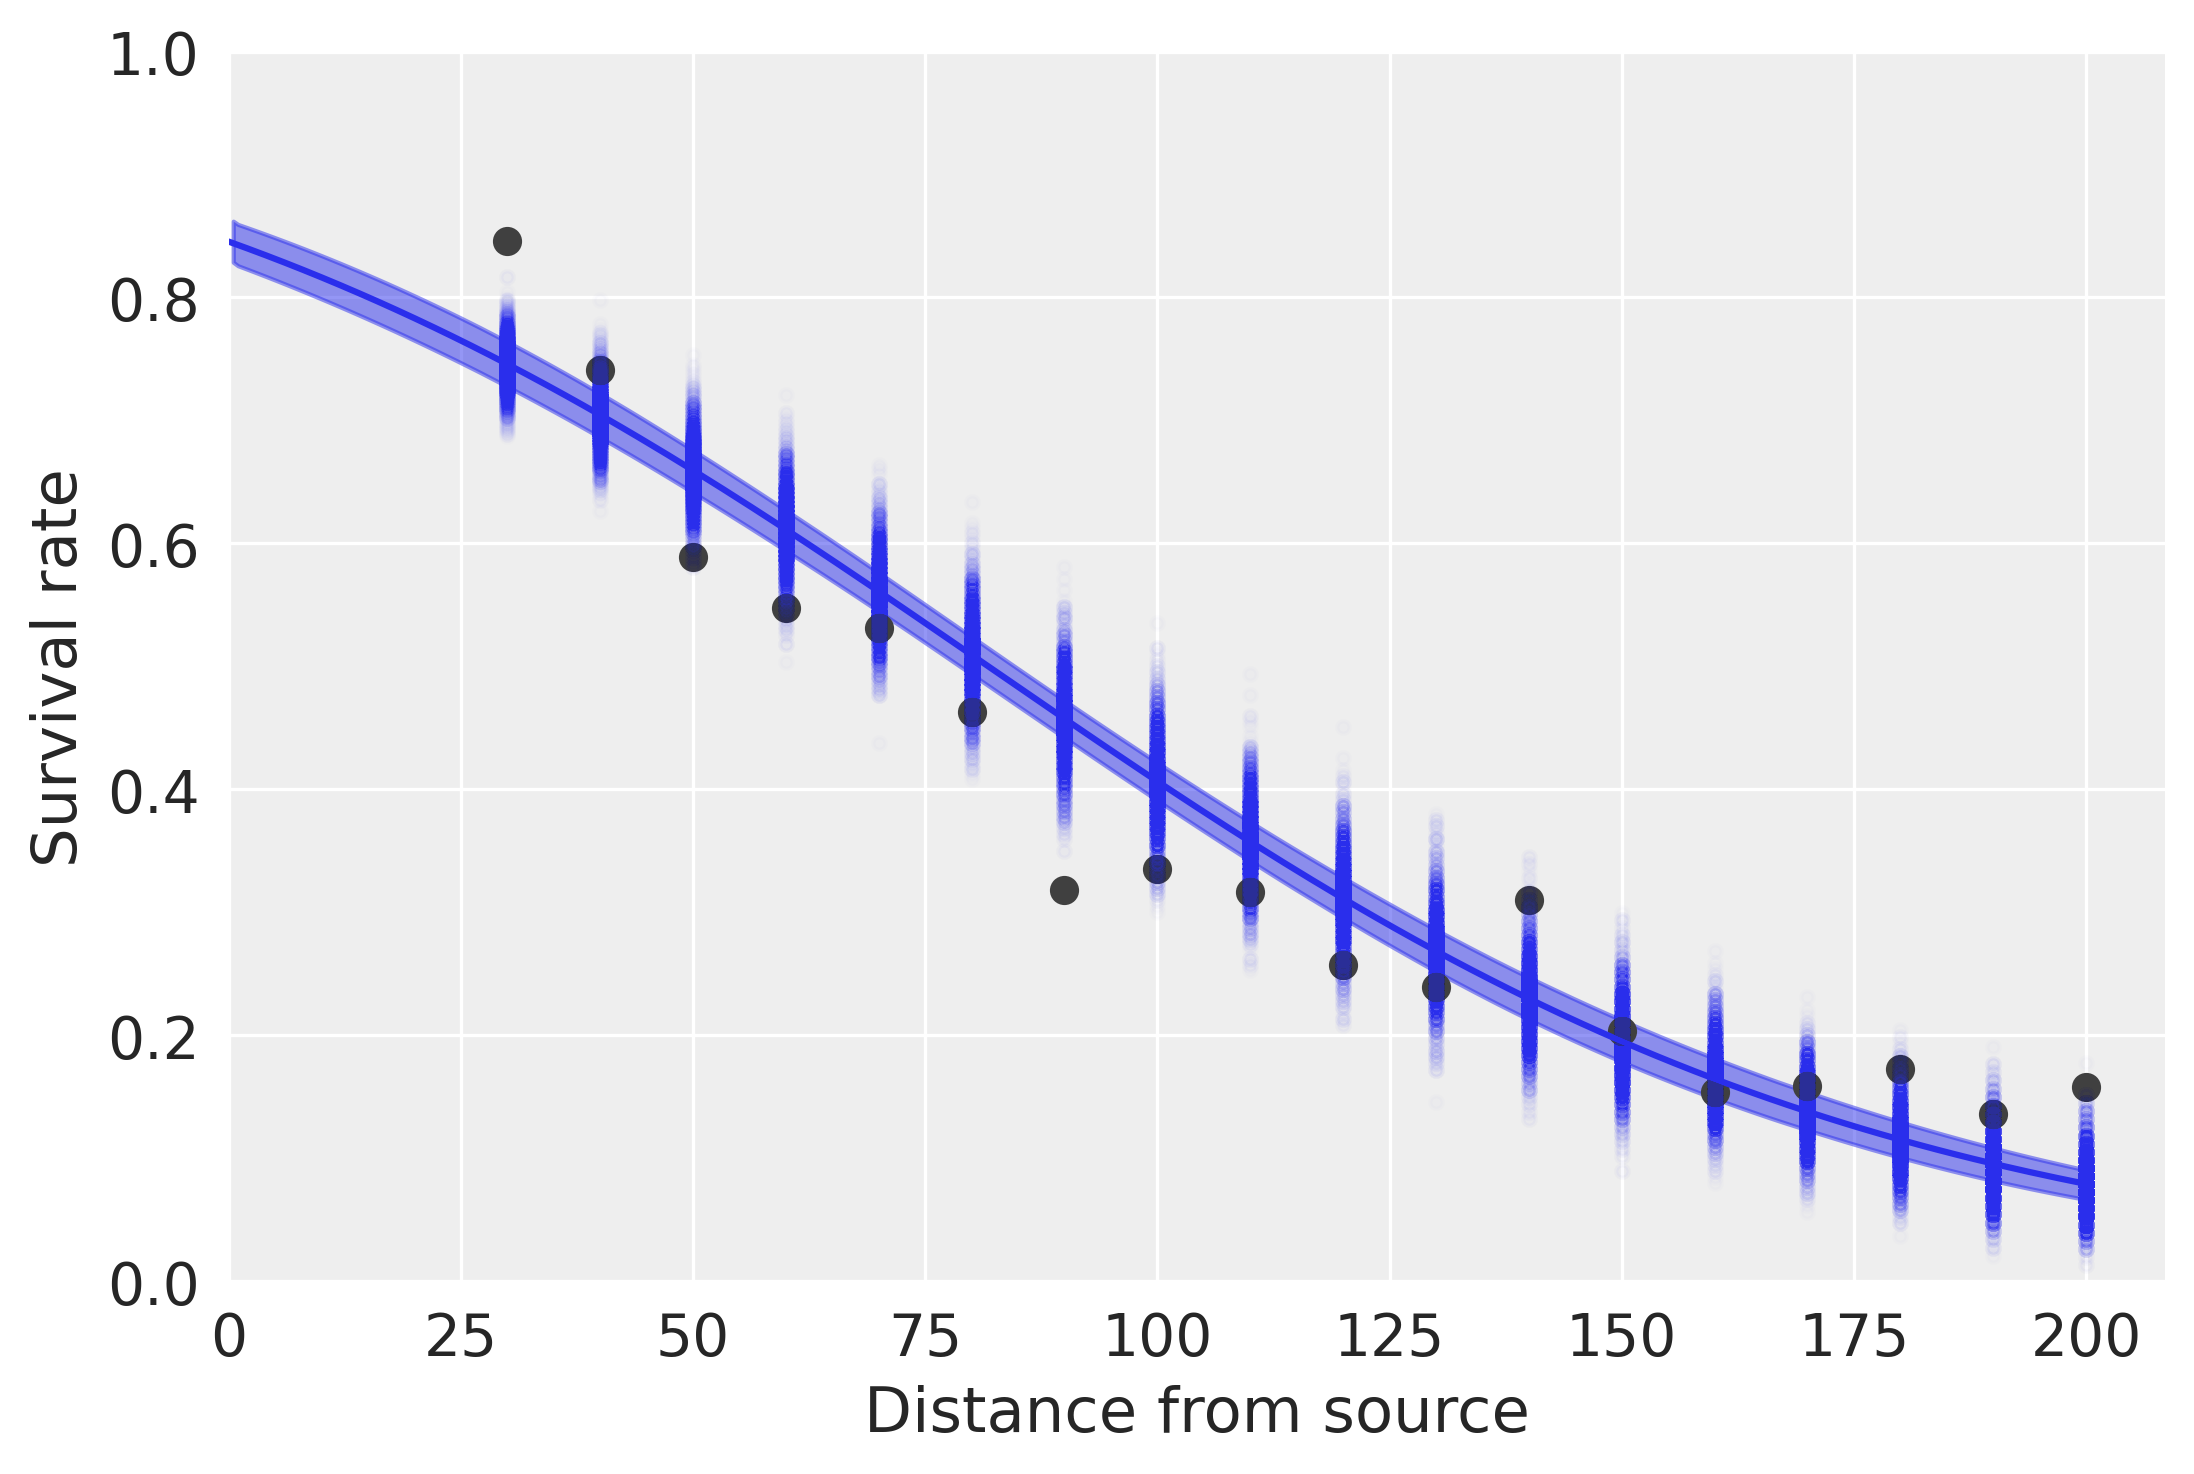

In [10]:
logistic_ppc_s = logistic_ppc["Y"].T / tries[:,None]
logistic_posterior = idata_logistic.posterior.stack(draws=["chain", "draw"])

# Plotting
ax = plot_survival_data(survival_data)
t = np.linspace(0, distance.max(), 200)

mean_distribution = scipy.special.expit(logistic_posterior["α"].values[:,None] +
                                        logistic_posterior["β"].values[:,None] * t)
ax.plot(t, mean_distribution.mean(axis=0), color="C0")
az.plot_hdi(t, mean_distribution, color="C0")

ax.plot(distance, logistic_ppc_s, "C0.", alpha=0.01);
plt.savefig("logistic_regression.png")

## Geometry-based model

As a second pass at modelling this data, both to improve fit and to increase confidence in extrapolation, we think about the geometry of the situation.

The survival of the seed depends on finding a suitable soil. This is not a problem of just distance, but of direction, if the sutiable soil is xx cm right under the surface. Moving a seed xx cm on the surface plane will make no difference on the survival rate. We can represent this with the following drawing...

dibujito

Given this model the probability of sruvival is given by:

$$
p(\text{success} \mid \sigma_{\text{angle}}, \text{distance}) = 2 \Phi\left( \frac{ \sin^{-1} \left(\frac{R}{\text{distance}} \right) }{\sigma}\right),
$$

where $\Phi$ is the normal cumulative density function, $R$ is the radius of the suitable soil (we are assumming a circular shape), and $\sigma$ is the radius of the golf ball (around 0.84 inches).

To get a feeling for this model, let's look at a few manually plotted values for $\sigma_{\text{angle}}$.

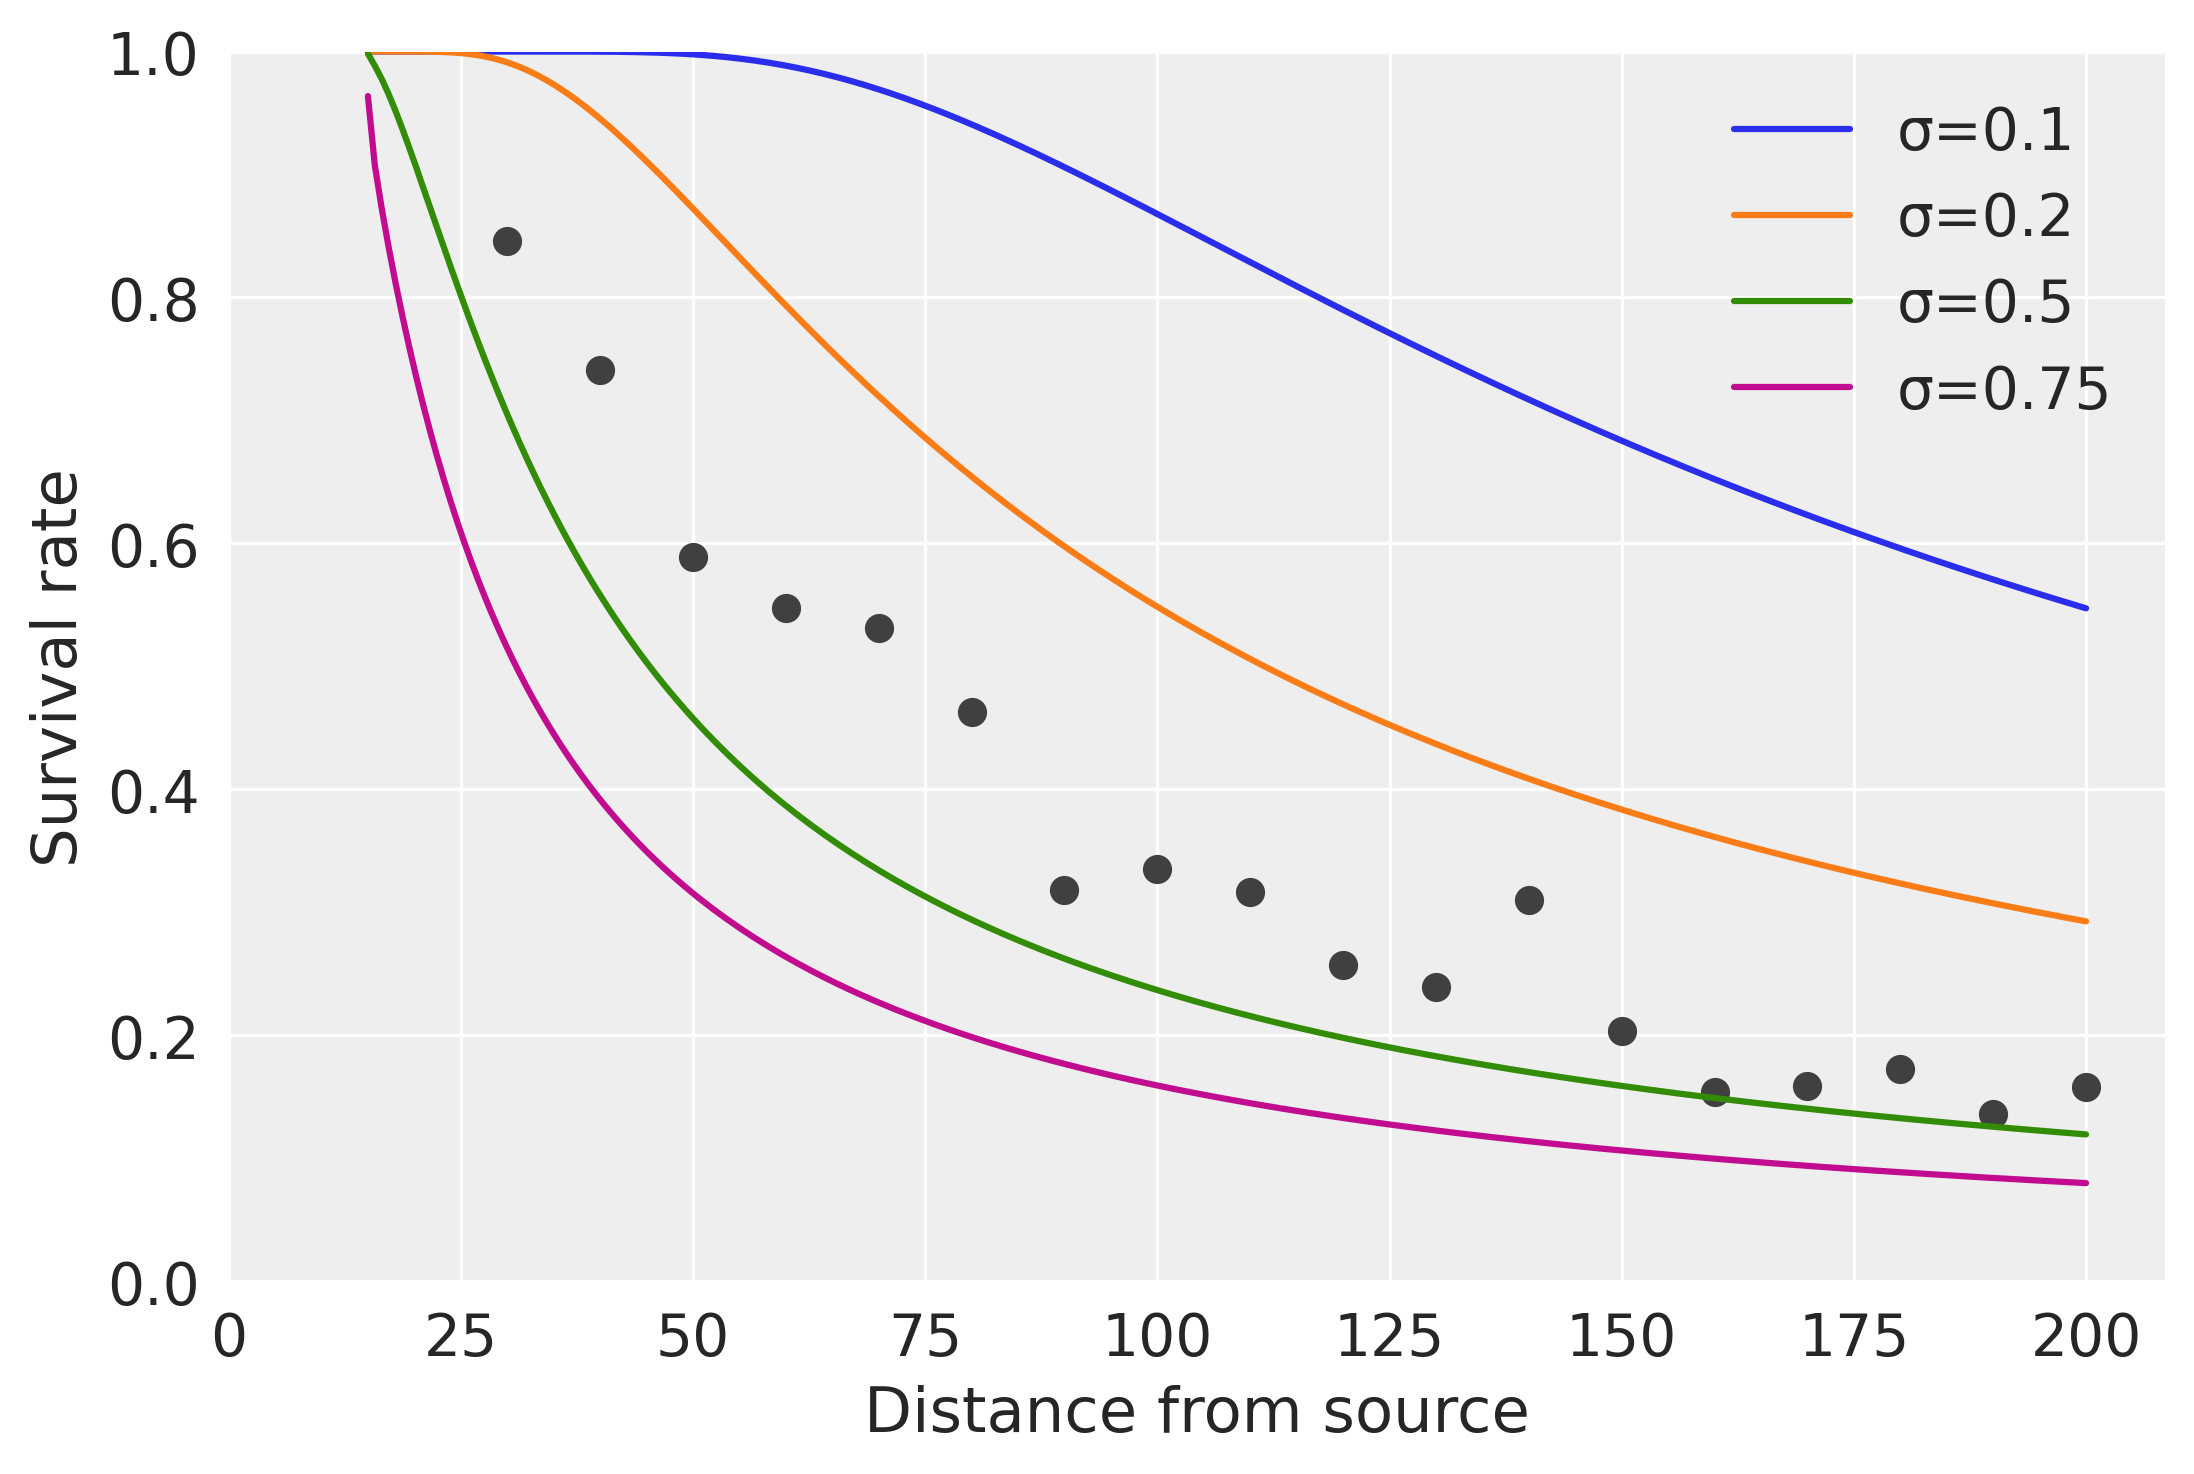

In [11]:
R = 15

def forward_angle_model(sigma, d):
    da = np.arcsin(R / d)
    return 2 * st.norm(0, sigma).cdf(da) - 1


ax = plot_survival_data(survival_data)

d = np.linspace(R, distance.max(), 250)

for sigma in (0.1, 0.2, 0.5, 0.75):
    ax.plot(d, forward_angle_model(sigma, d), label=f"σ={sigma}")

ax.legend()
plt.savefig("geometric_fit_arbitrary_variance.png")

From the previous figure we can see that a $\sigma$ value between 0.01 and 0.02 radians could provide a good fit. The model also predicted that seeds at 0 distance will all survive, which may be a little bit overoptimistics, given that the higest germination rates are not higher than XX%.


### Fitting the model

In [12]:
def Phi(x):
    """Calculates the standard normal cumulative distribution function.
    
    This expression use an identity with the error function.
    See https://en.wikipedia.org/wiki/Error_function for more details.
    """
    return 0.5 + 0.5 * tt.erf(x / tt.sqrt(2.0))


with pm.Model() as geometric_model:
    σ = pm.HalfNormal("σ", 1)
    θ = 2 * Phi(tt.arcsin((R) / distance) / σ) - 1
    Y = pm.Binomial("Y",
                    n=tries,
                    p=θ,
                    observed=successes,
                    )

    idata_geometric = pm.sample(1000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


/home/osvaldo/proyectos/00_BM/arviz/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/home/osvaldo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/osvaldo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arcsin
  after removing the cwd from sys.path.
/home/osvaldo/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1922: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
/home/osvaldo/proyectos/00_BM/arviz/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  Fut

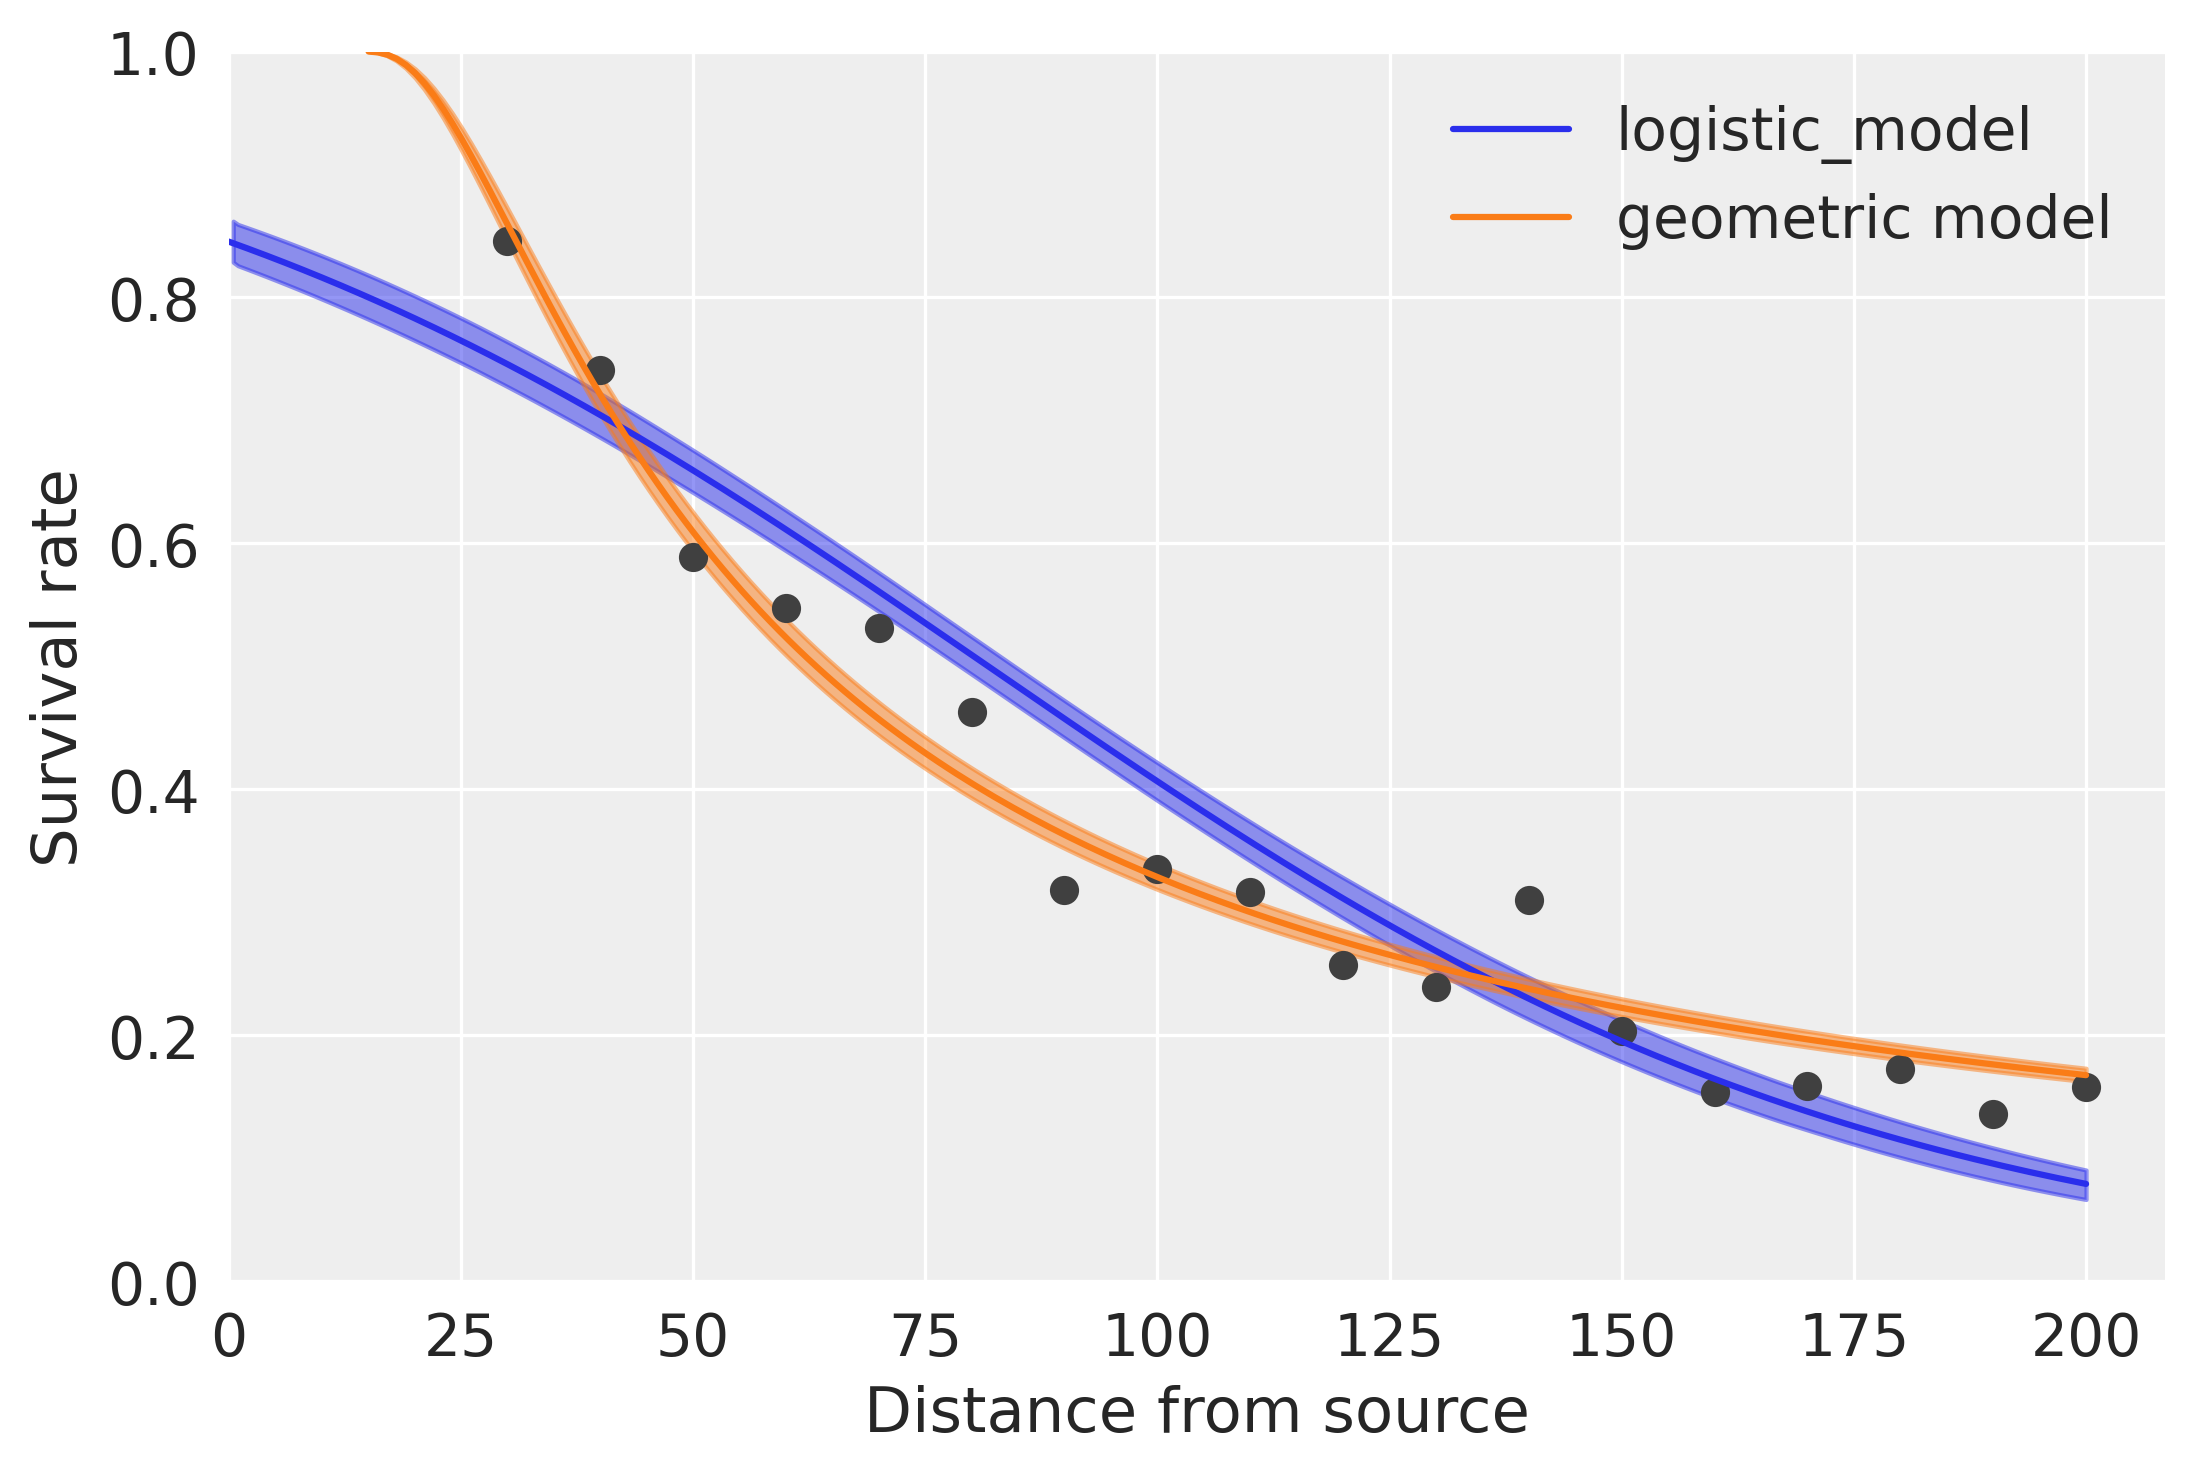

In [13]:
ax = plot_survival_data(survival_data)

d = np.linspace(0, distance.max(), 200)

geometric_posterior = idata_geometric.posterior.stack(draws=["draw", "chain"])

mean_distribution = scipy.special.expit(logistic_posterior["α"].values[:,None] +
                                        logistic_posterior["β"].values[:,None] * t)
ax.plot(d, mean_distribution.mean(axis=0), color="C0", label="logistic_model")
az.plot_hdi(d, mean_distribution, color="C0")


mean_distribution = forward_angle_model(geometric_posterior["σ"].values[:,None], t)
                                        
ax.plot(d, mean_distribution.mean(axis=0), color="C1", label="geometric model")
az.plot_hdi(d, mean_distribution, color="C1", smooth=False)

ax.legend()
plt.savefig("logistic_vs_geometric_model.png")

In [14]:
cmp = az.compare({"logistic":idata_logistic,"geom":idata_geometric})
cmp

/home/osvaldo/proyectos/00_BM/arviz/arviz/stats/stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/home/osvaldo/proyectos/00_BM/arviz/arviz/stats/stats.py:693: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
geom,0,-65.452586,1.433673,0.000000,0.917506,3.936543,0.000000,False,log
logistic,1,-117.544053,18.216221,52.091467,0.082494,26.791169,26.699134,True,log


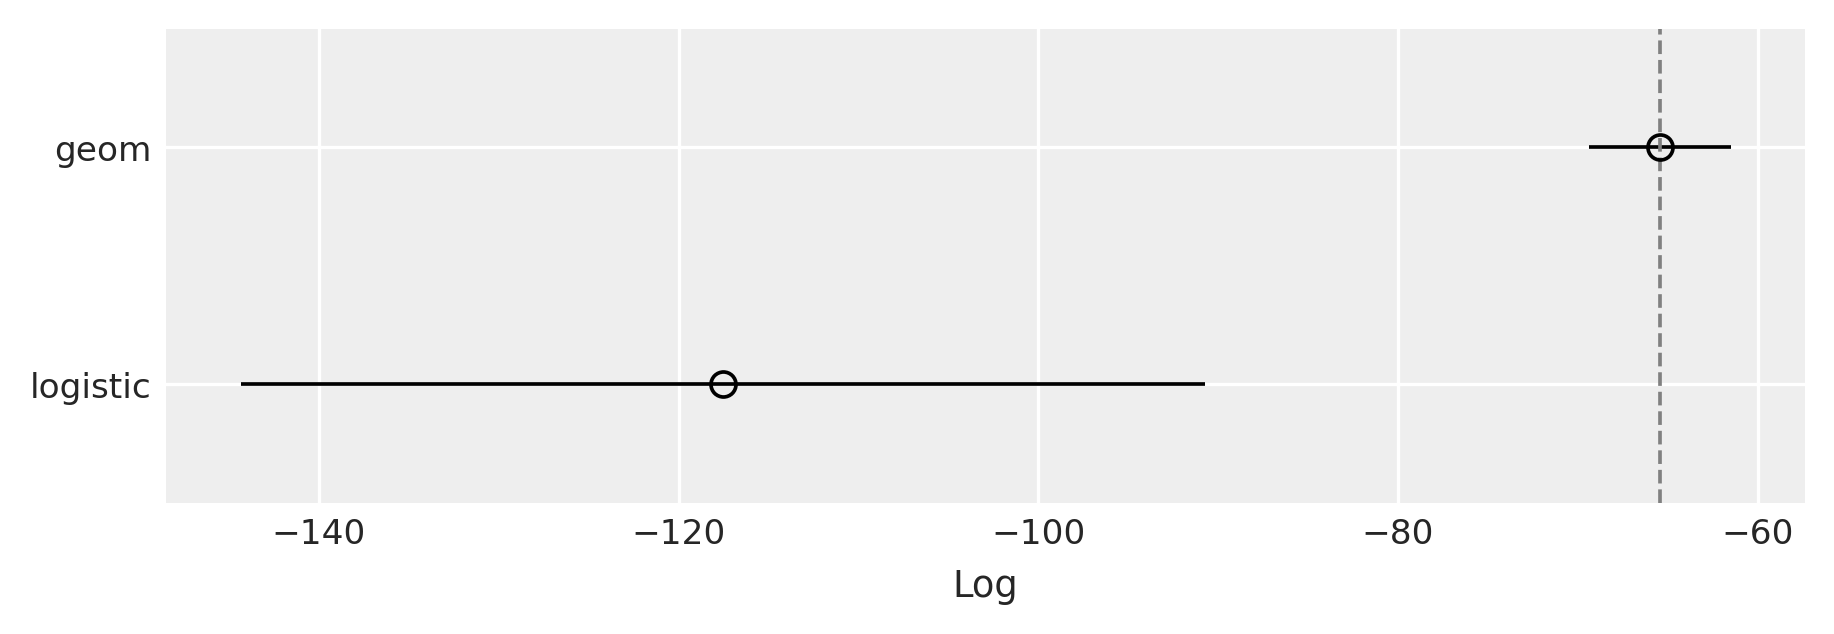

In [15]:
az.plot_compare(cmp, insample_dev=False, plot_ic_diff=False)
plt.savefig("LOO.png")

In [16]:
#geometric_ppc = pm.sample_posterior_predictive(idata_geometric, model=geometric_model)
#geometric_ppc_s = geometric_ppc["Y"].T / tries[:,None]

#observed_survival_rate = successes / tries
#residuals_logistic = abs(observed_survival_rate - logistic_ppc_s.mean(1))
#residuals_geometric = abs(observed_survival_rate - geometric_ppc_s.mean(1))

#_, ax = plt.subplots()
#ax.plot(distance, residuals_logistic, "o-", label="logistic model")
#ax.plot(distance, residuals_geometric, "o-", label="geometric model")

#ax.legend()
#ax.set_xlabel("Distance")
#ax.set_ylabel("Absolute error")
#plt.savefig("residuals.png")

In [17]:
587/694 

0.845821325648415

In [18]:
logistic_loo = az.loo(idata_logistic, pointwise=True)
geometric_loo = az.loo(idata_geometric, pointwise=True)

/home/osvaldo/proyectos/00_BM/arviz/arviz/stats/stats.py:693: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


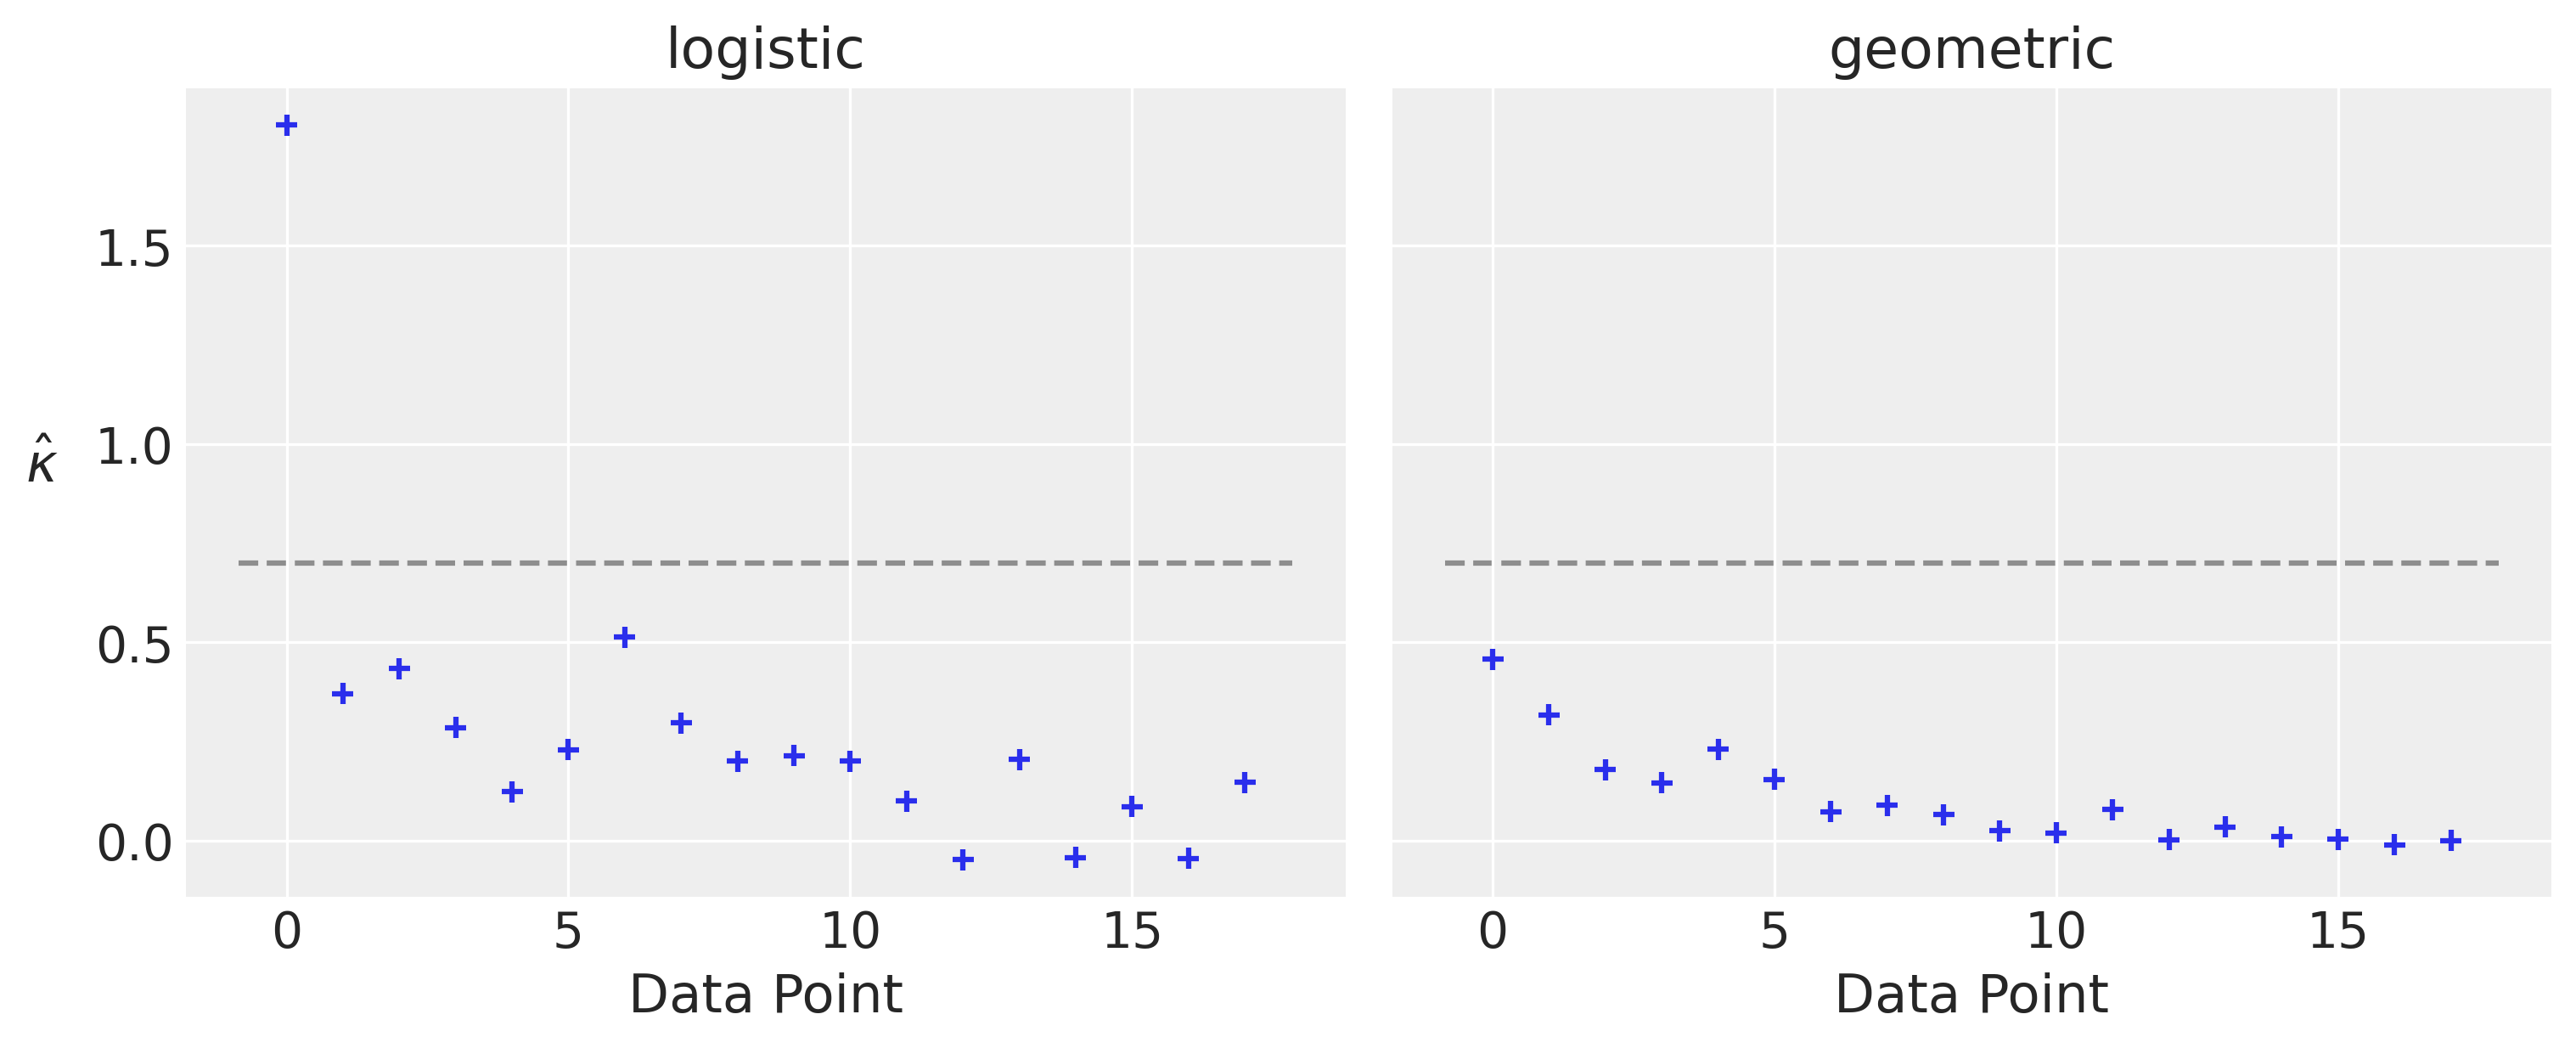

In [19]:
_, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for idx, (model, title) in enumerate(zip((logistic_loo, geometric_loo),("logistic", "geometric"))):
    az.plot_khat(model.pareto_k, ax=ax[idx], show_hlines=0.7,
                 hlines_kwargs={"hlines":0.7, "color":"0.4", "ls":"--"})
    ax[idx].set_title(title)
ax[0].set_ylabel("$\hat \kappa$", rotation=0, labelpad=15)
ax[1].set_ylabel("")
plt.savefig("k_hat.png")

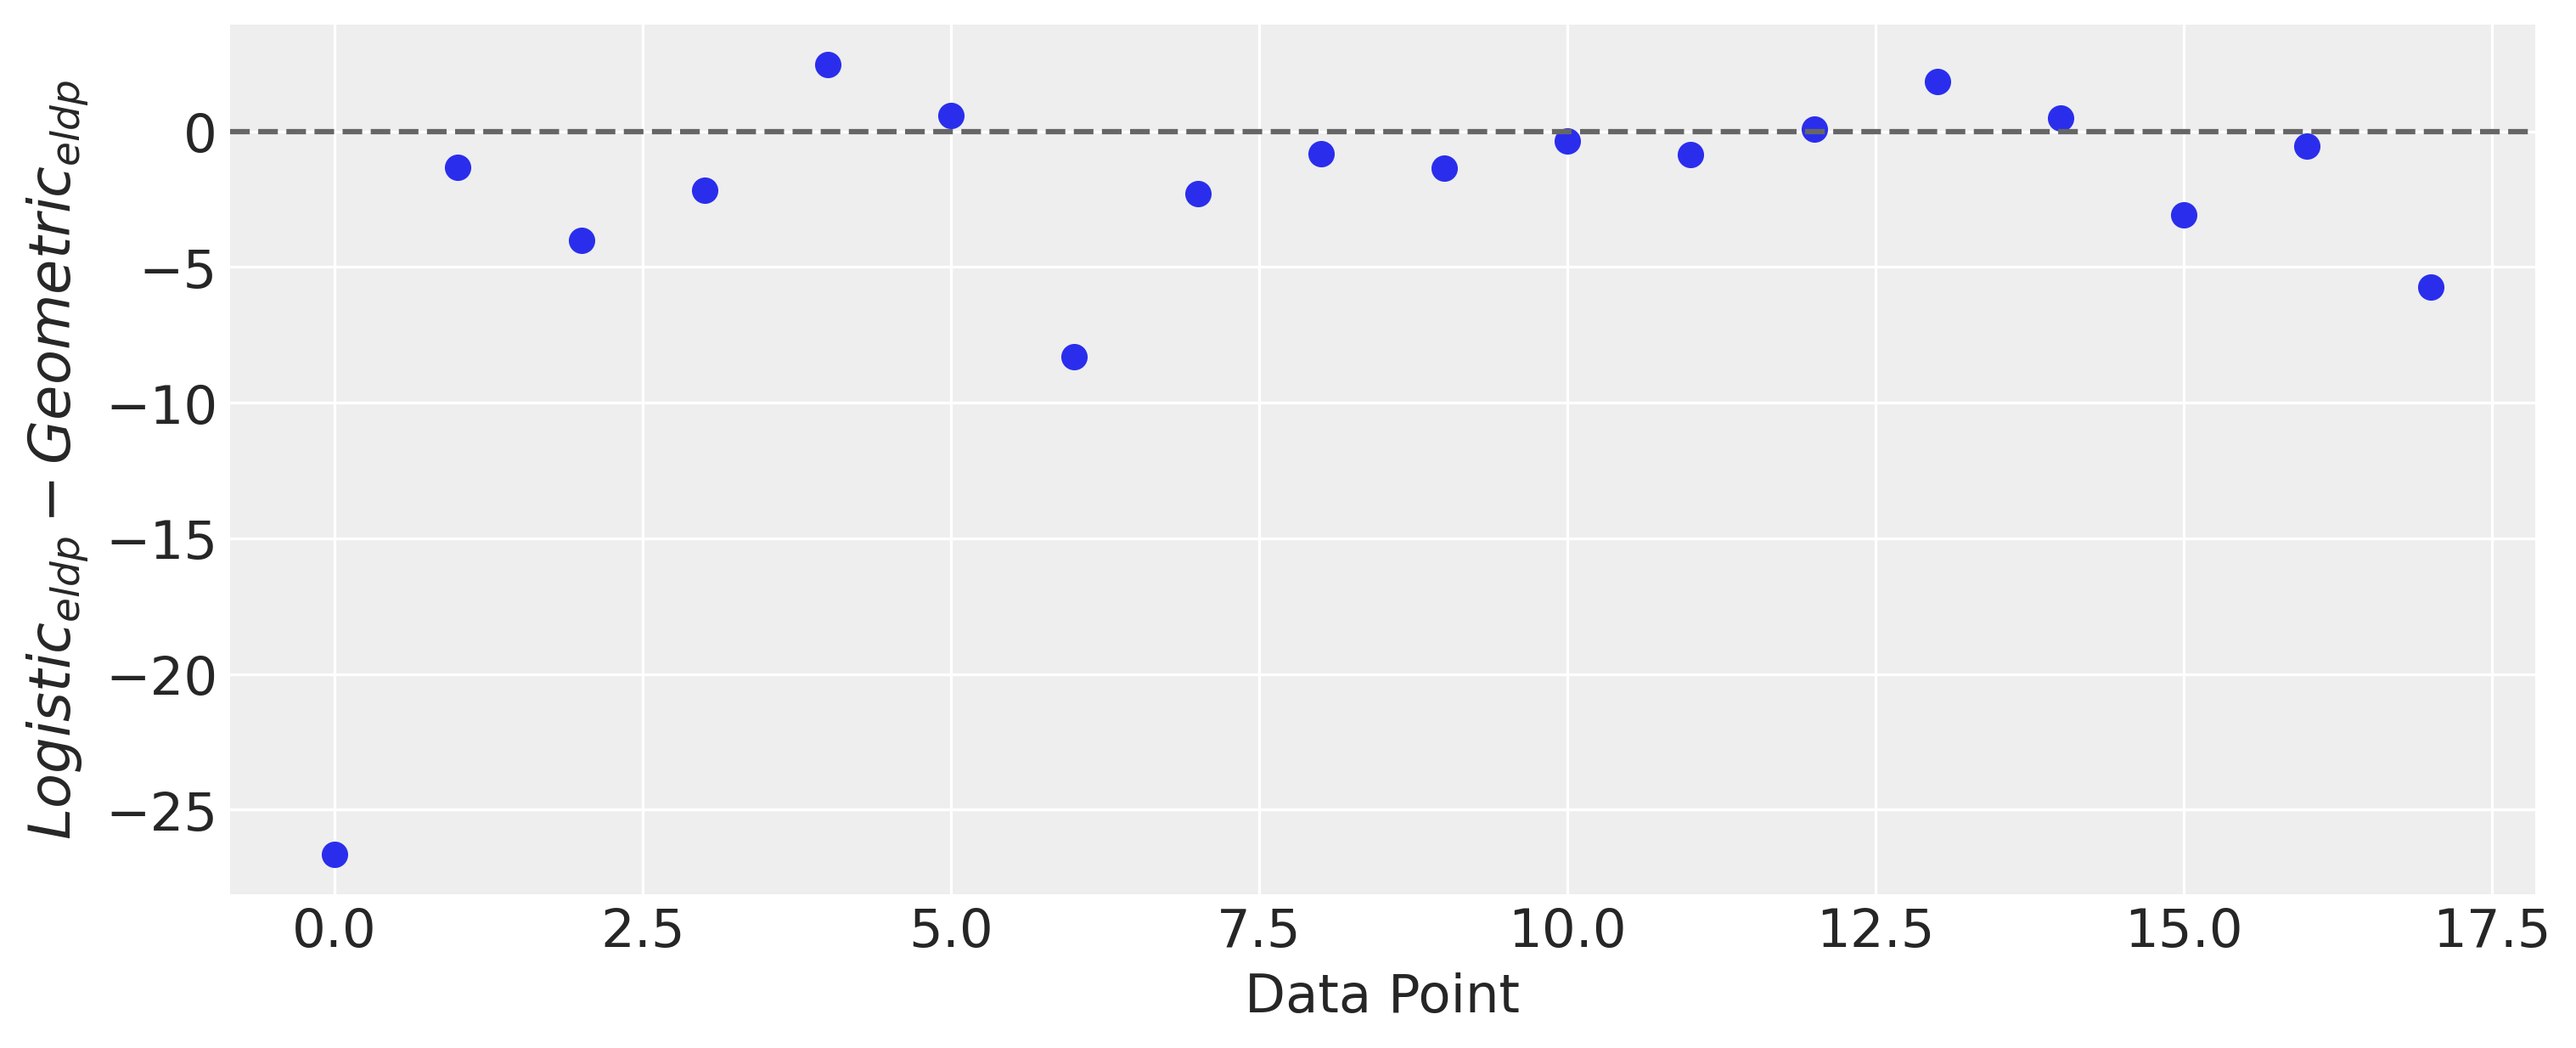

In [20]:
ax = az.plot_elpd({"logistic":logistic_loo,
                   "geometric":geometric_loo},
                  figsize=(10, 4))
ax.axhline(0, color="0.4", ls="--")
ax.set_title("")
ax.set_xlabel("Data Point")
ax.set_ylabel(r"$Logistic_{eldp}-Geometric_{eldp}$")
plt.savefig("elpd_difference.png")

# Convergence diagnostics

Most modern Bayesian analysis relies on Markov Chain Monte Carlo methods to numerically compute the posterior. The details of how such methods work are generally not important from the practitioner point of view. One important element to keep in mind is that we are getting samples from the posterior, thus everytime we "fit" a Bayesian model using an MCMC methods we will get a slightly different answer. Also as the MCMC may fail under certain circunstances it is important to diagnose the sampling process before making conclusions.

We can also check the r_hat value, which should ideally be < 1.01, the ESS_bulk which should be... and if this two looks ok, we then should check that the mcse error is below the level of accuracy we want/need to report

In [33]:
print(az.summary(idata_geometric, kind="diagnostics", round_to=4)[["mcse_mean", "ess_bulk", "r_hat"]].to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  mcse\_mean &  ess\_bulk &   r\_hat \\
\midrule
σ &     0.0002 &  947.1448 &  1.0016 \\
\bottomrule
\end{tabular}



### Prior Predictive Checks

In [22]:
with pm.Model() as logistic_vague:
    α = pm.Normal("α", 1)
    β = pm.Normal("β", 1)
    θ = pm.math.invlogit(α + β * distance)
    
    Y = pm.Binomial("Y",
                    n=tries,
                    p=θ,
                    observed=successes,
                    )
    
with pm.Model() as logistic_weakly_informative:
    α = pm.HalfNormal("α", 1)
    β = -pm.HalfNormal("β", 1)
    θ = pm.math.invlogit(α + β * distance)
    
    Y = pm.Binomial("Y",
                    n=tries,
                    p=θ,
                    observed=successes,
                    )
    
with pm.Model() as logistic_informative:
    α = pm.HalfNormal("α", 1)
    β = -pm.HalfNormal("β", 0.02)
    θ = pm.math.invlogit(α + β * distance)
    
    Y = pm.Binomial("Y",
                    n=tries,
                    p=θ,
                    observed=successes,
                    )

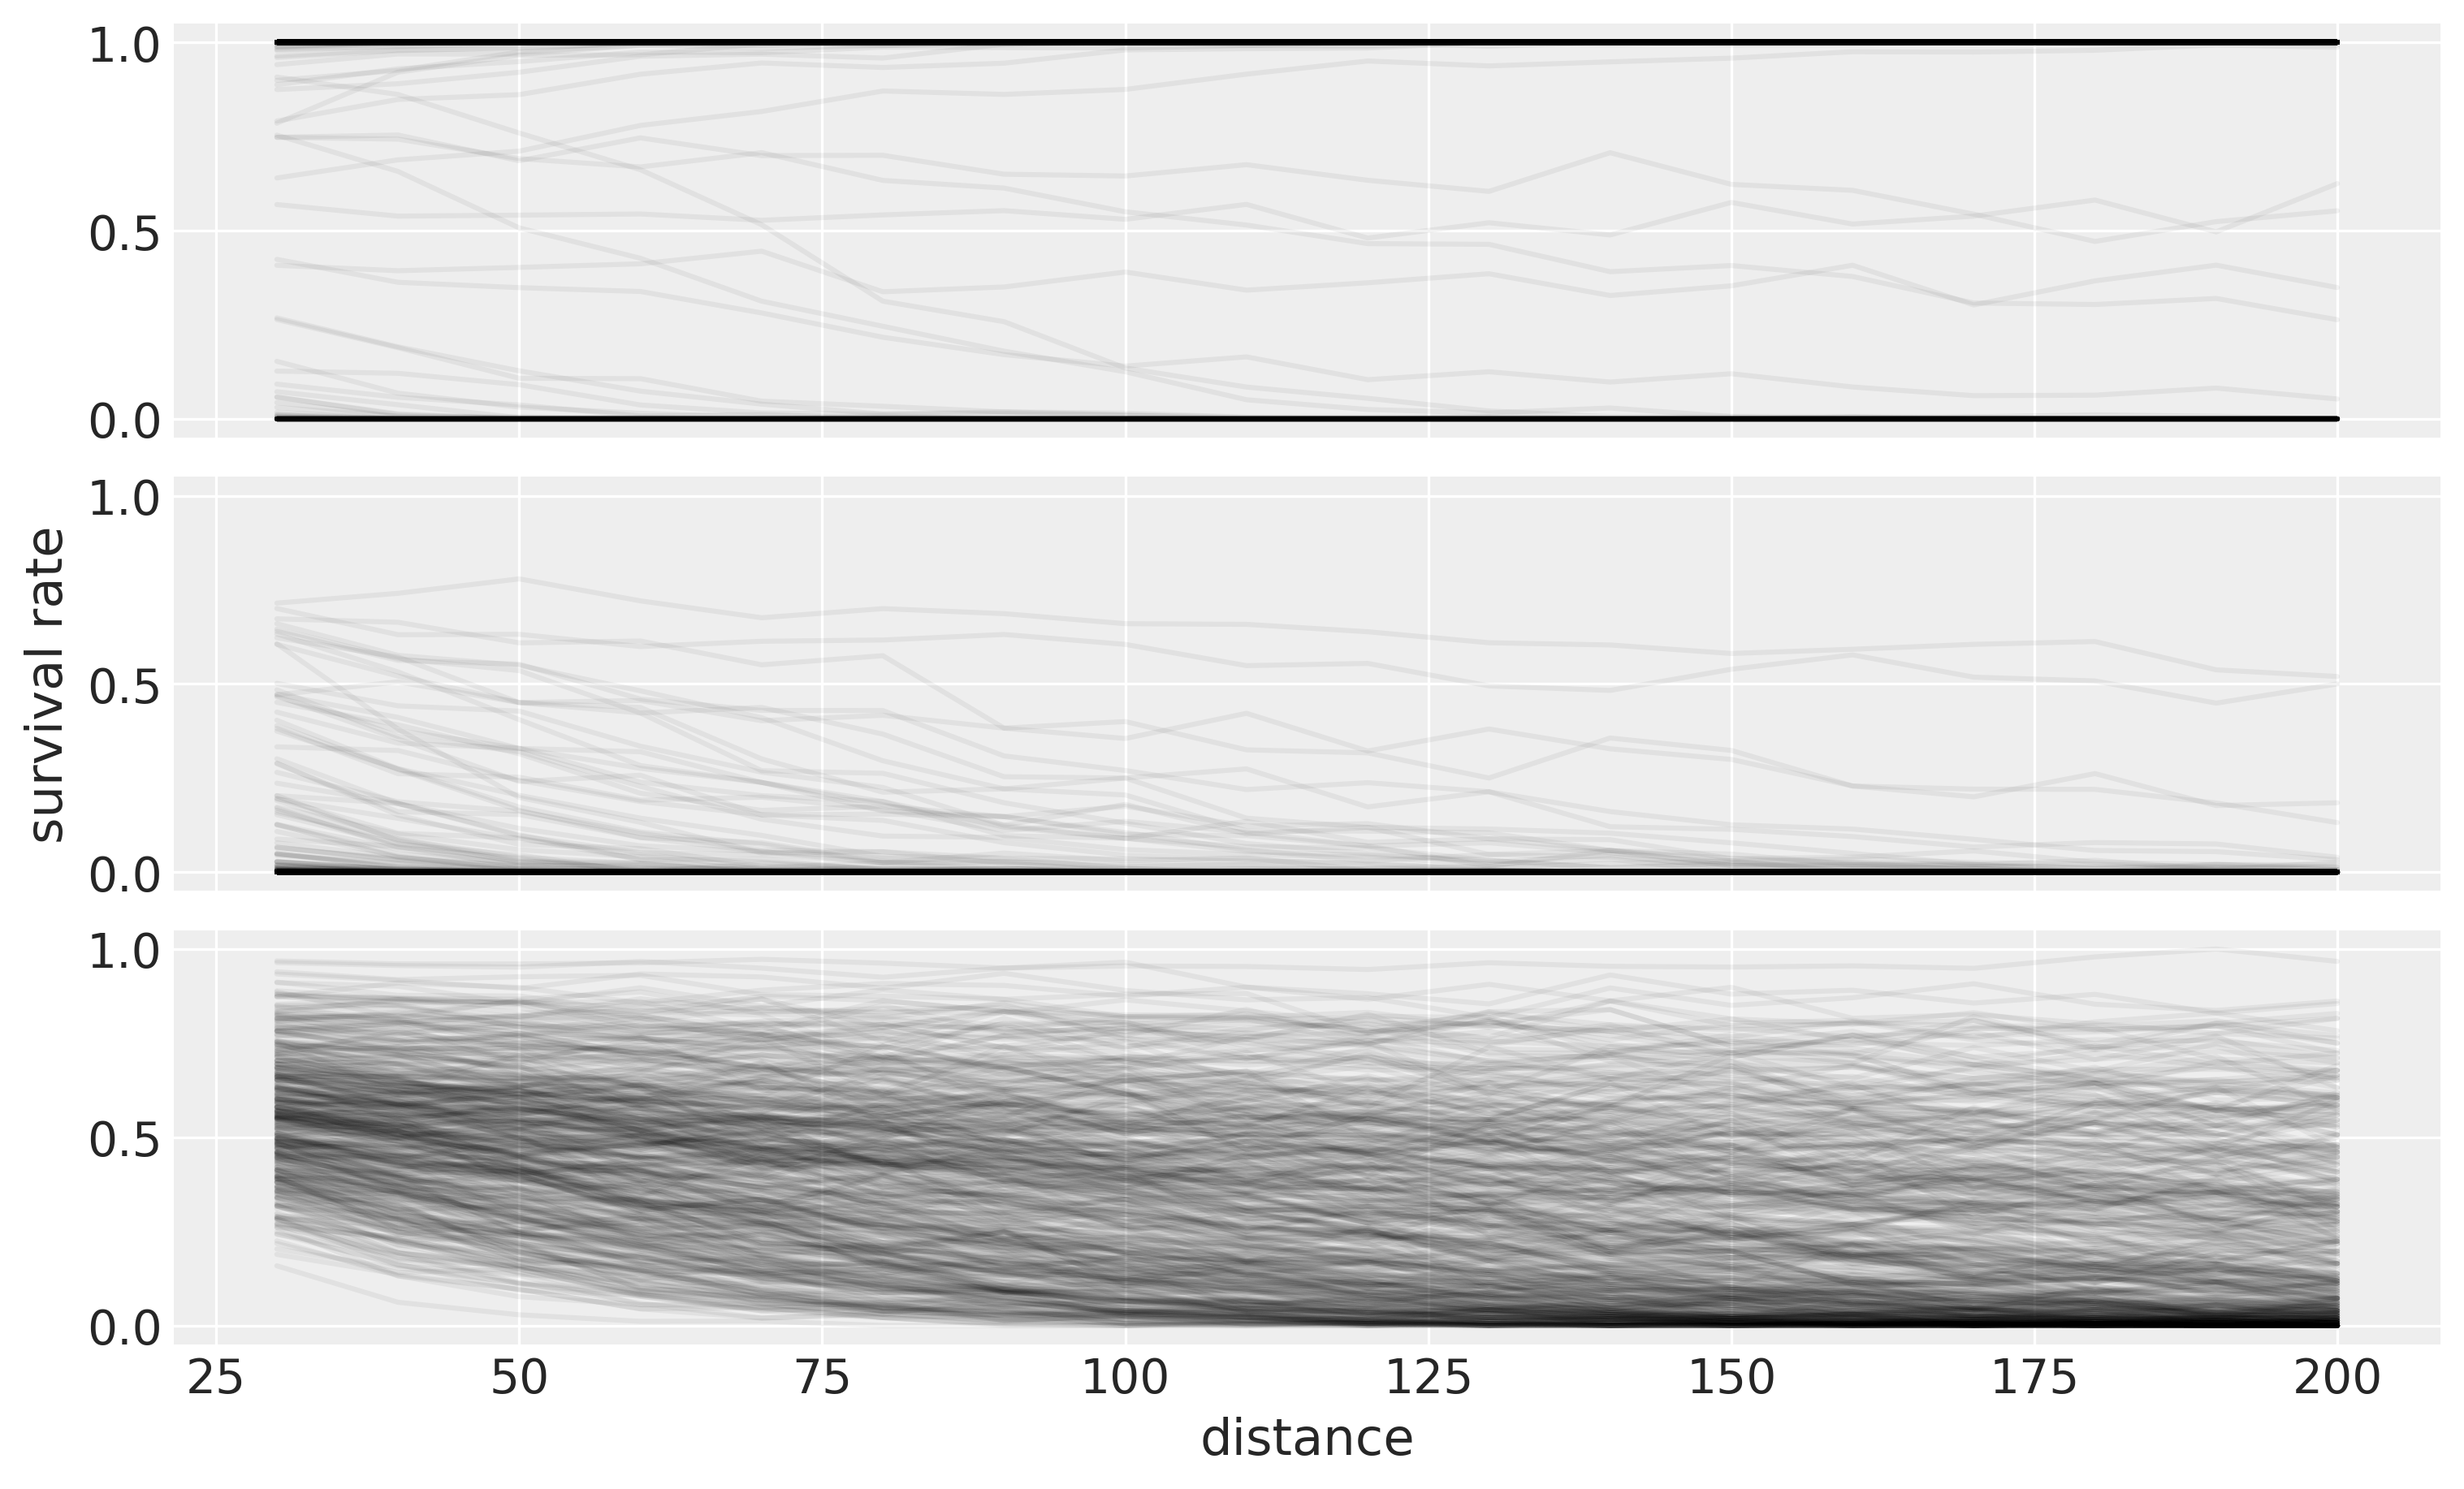

In [23]:
_, ax = plt.subplots(3,1, figsize=(10, 6), sharex=True, sharey=True)
for idx, model in enumerate((logistic_vague,
                             logistic_weakly_informative,
                             logistic_informative)):
    
    prior_samples = pm.sample_prior_predictive(model=model)["Y"]
    ax[idx].plot(distance, (prior_samples/tries).T, color="k", alpha=0.05)

ax[2].set_xlabel("distance")
ax[1].set_ylabel("survival rate")
plt.savefig("prior_predictive_distributions.png")

### Posterior predictive checks

In [24]:
ps_logistic = pm.sample_posterior_predictive(idata_logistic, 1000, model=logistic_model)["Y"]
ps_geometric = pm.sample_posterior_predictive(idata_geometric, 1000, model=geometric_model)["Y"]

/home/osvaldo/proyectos/00_BM/pymc3/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


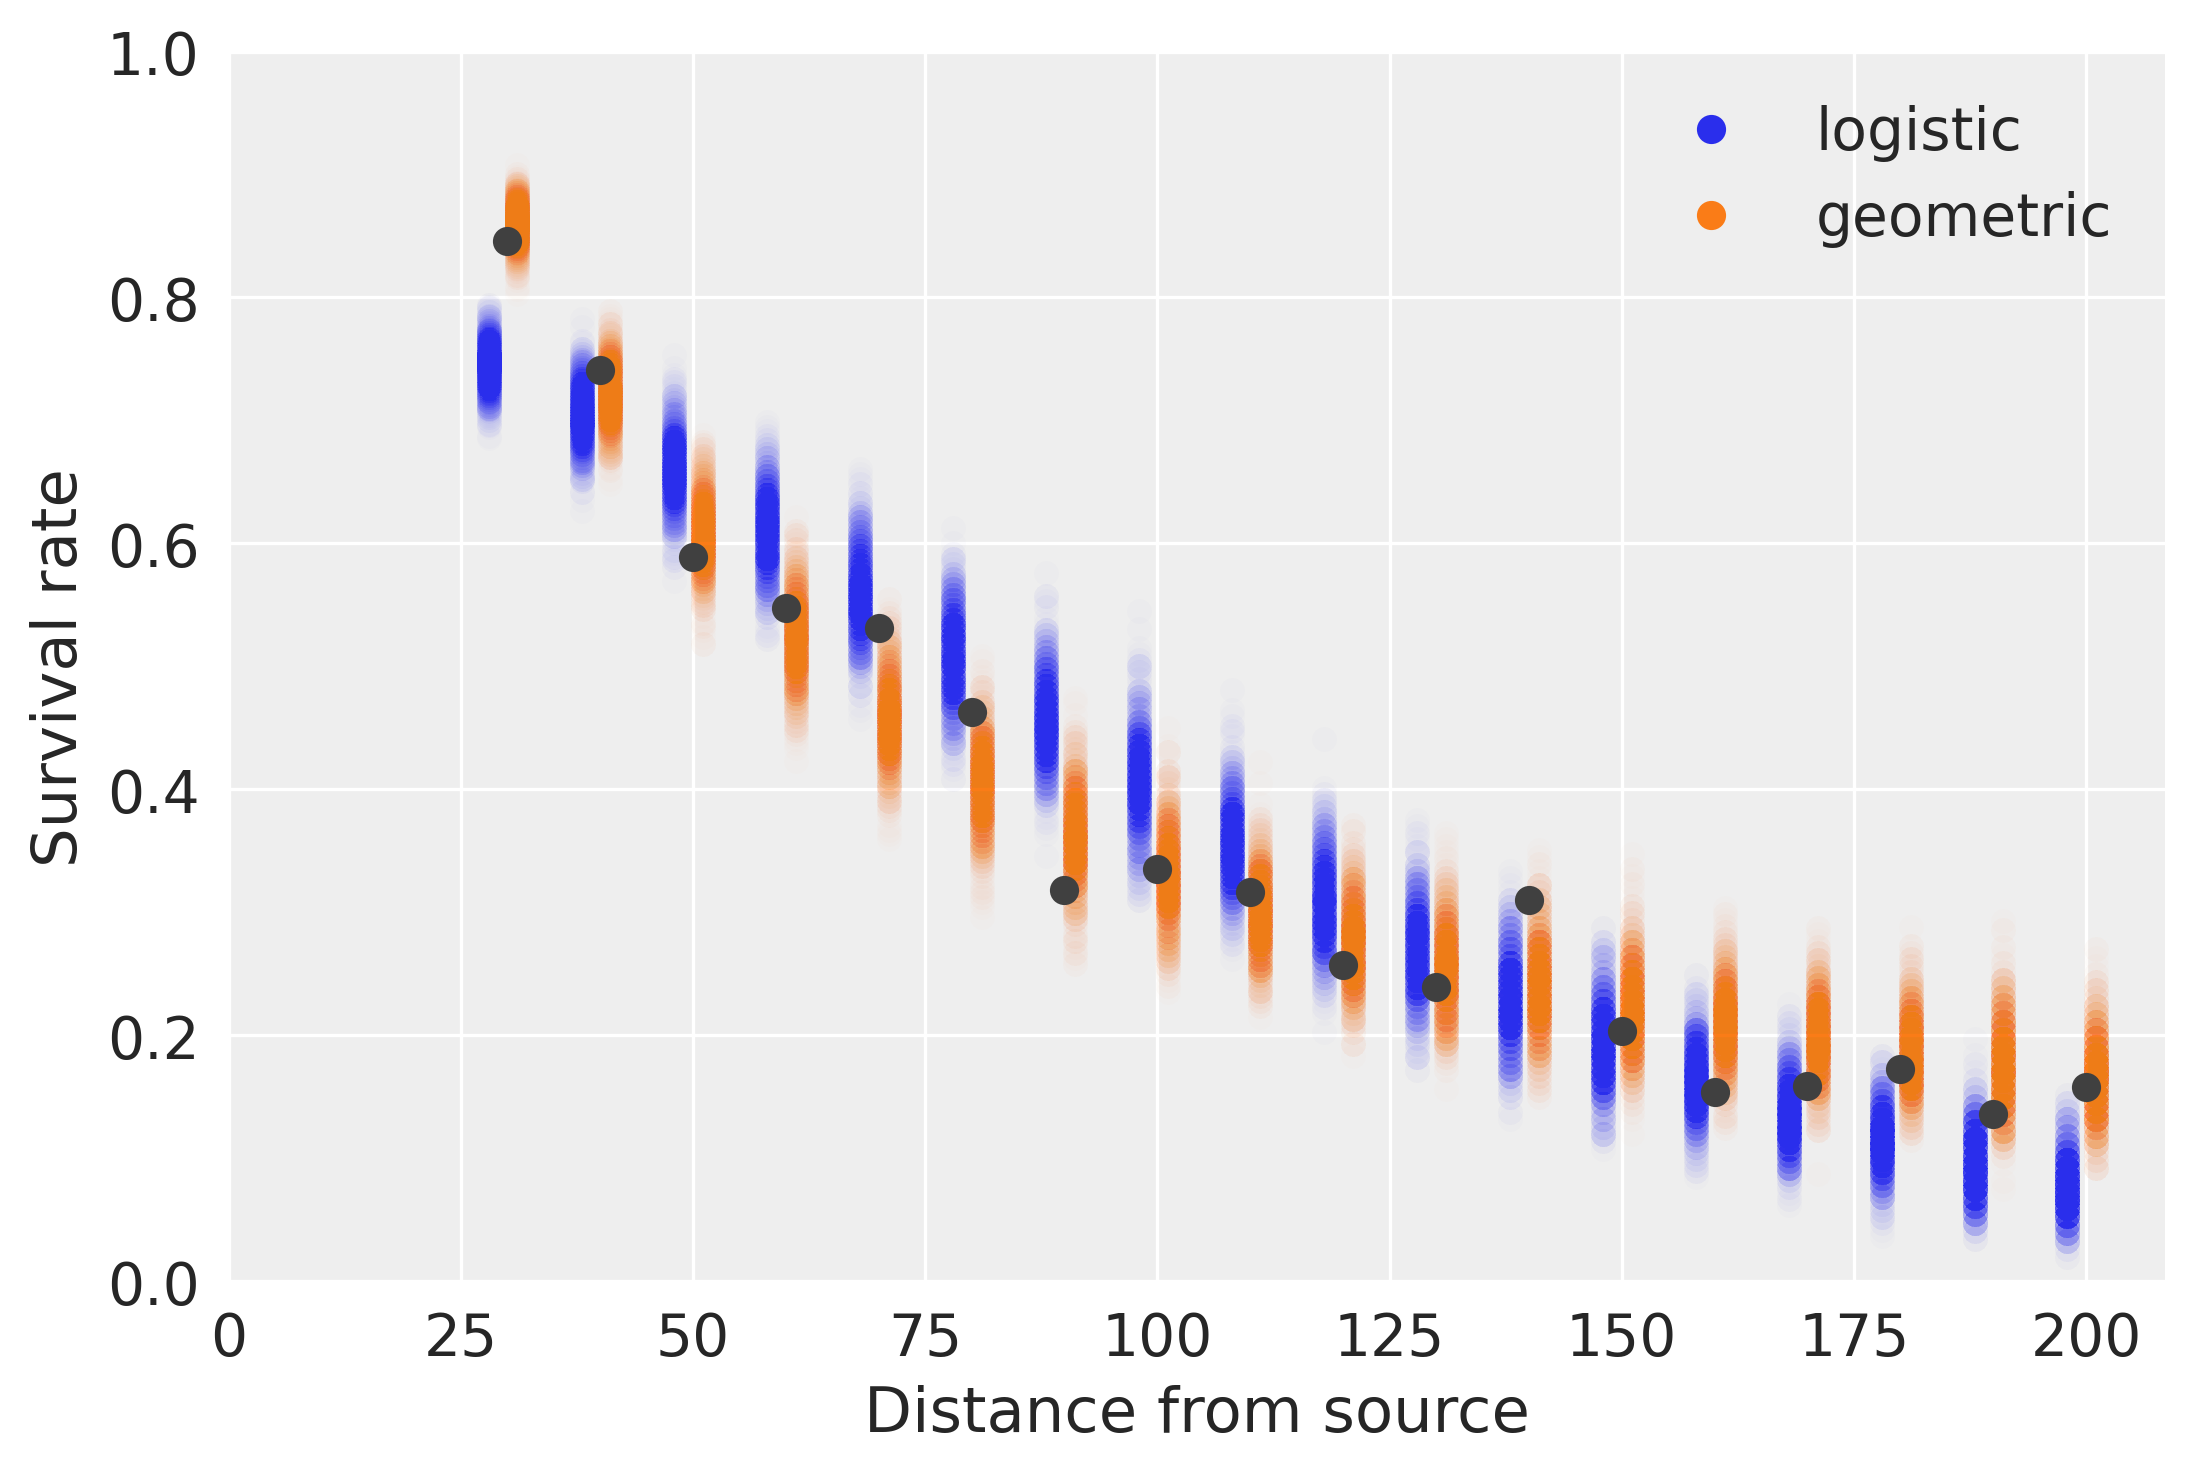

In [25]:
ax = plot_survival_data(survival_data)
for idx, (ps, name, c, offset) in enumerate(zip((ps_logistic, ps_geometric),
                                           ("logistic", "geometric"),
                                           ("C0", "C1"),
                                           (-1-1, 1.1),
                                            )):
    
    ax.plot(distance+offset, (ps/tries).T, 'o', color=c, mec="None", alpha=0.01, zorder=1)
    ax.plot([], 'o', color=c, label=name)

ax.legend(loc="upper right")
plt.savefig("posterior_predictive_distributions.png")